# Tutorial 19: Mean Entropic Drawdown at Risk (EDaR) Optimization

## 1. Downloading the data:

In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2019-12-30'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%%**********************]  25 of 25 completed


In [14]:
# Calculating returns

Y = data[assets].pct_change().dropna()

display(Y.head())

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-2.0257%,0.4057%,0.4035%,1.9693%,0.0180%,0.9305%,0.3678%,0.5783%,0.9483%,-1.1953%,...,1.5881%,0.0212%,2.8236%,0.9758%,0.6987%,1.7539%,-0.1730%,0.2410%,1.3735%,-1.0858%
2016-01-06,-11.4863%,-1.5879%,0.2412%,-1.7557%,-0.7727%,-1.2473%,-0.1736%,-1.1239%,-3.5867%,-0.9551%,...,0.5547%,0.0212%,0.1592%,-1.5646%,0.3108%,-1.0155%,-0.7653%,-3.0048%,-0.9035%,-2.9144%
2016-01-07,-5.1388%,-4.1922%,-1.6573%,-2.7699%,-1.1047%,-1.9769%,-1.2207%,-0.8855%,-4.6058%,-2.5394%,...,-2.2066%,-3.0309%,-1.0410%,-3.1557%,-1.6148%,-0.2700%,-2.2845%,-2.0570%,-0.5492%,-3.0020%
2016-01-08,0.2736%,-2.2705%,-1.6037%,-2.5425%,0.1099%,-0.2241%,0.5707%,-1.6403%,-1.7642%,-0.1649%,...,-0.1539%,-1.1366%,-0.7308%,-0.1449%,0.0895%,-3.3838%,-0.1117%,-1.1387%,-0.9719%,-1.1254%
2016-01-11,-4.3384%,0.1693%,-1.6851%,-1.0216%,0.0915%,-1.1791%,0.5674%,0.5288%,0.6616%,0.0330%,...,1.6436%,0.0000%,0.9869%,-0.1450%,1.2224%,1.4570%,0.5367%,-0.4607%,0.5800%,-1.9918%


## 2. Estimating Mean EDaR Portfolios

### 2.1 Calculating the portfolio that maximizes Return/EDaR ratio.

### Entropic Drawdown at Risk (EDaR)

Entropic Drawdown at Risk (EDaR)은 포트폴리오 리스크 관리에서 사용되는 첨단 리스크 측정 도구입니다. 이 리스크 측정 방법은 포트폴리오의 최악의 손실을 측정하는 데 사용되며, 투자자들이 예상치 못한 시장 변화로 인한 손실을 더 잘 이해하고 대비할 수 있도록 도와줍니다.

#### EDaR의 주요 개념

1. **Drawdown**: Drawdown은 포트폴리오 가치의 최고점에서 최저점까지의 하락을 의미합니다. 이는 포트폴리오가 최고점에서 얼마나 손실을 입었는지를 나타내며, 투자자가 겪을 수 있는 최대 손실을 이해하는 데 중요합니다.

2. **Entropy**: 엔트로피는 불확실성이나 무질서를 측정하는 개념으로, 정보 이론에서 유래되었습니다. 금융에서는 포트폴리오 수익률의 불확실성을 측정하는 데 사용됩니다.

3. **Entropic Drawdown at Risk (EDaR)**: EDaR은 Drawdown을 엔트로피 개념과 결합하여 측정한 리스크입니다. 이는 특정 기간 동안 포트폴리오가 겪을 수 있는 최대 Drawdown을 통계적 엔트로피를 사용하여 추정합니다. 이 방법은 포트폴리오의 극단적인 손실을 더 정확하게 평가할 수 있게 해줍니다.

#### EDaR 계산 방법

1. **포트폴리오의 시간별 가치 측정**: 포트폴리오의 일일, 주간, 월간 가치 변화를 추적합니다.
2. **Drawdown 계산**: 각 시간 간격에서 포트폴리오 가치의 최고점에서 최저점까지의 하락을 계산합니다.
3. **엔트로피 계산**: 각 Drawdown에 대한 확률 분포를 사용하여 엔트로피를 계산합니다. 이는 다양한 Drawdown 시나리오의 불확실성을 측정합니다.
4. **EDaR 추정**: 엔트로피를 사용하여 포트폴리오가 특정 신뢰 수준에서 겪을 수 있는 최대 Drawdown을 추정합니다.

#### EDaR의 장점

1. **리스크 관리 향상**: EDaR은 투자자가 극단적인 시장 변동성을 이해하고 대비하는 데 도움을 줍니다.
2. **포트폴리오 최적화**: 투자자들은 EDaR을 사용하여 포트폴리오의 리스크를 최소화하고, 수익률을 최적화할 수 있습니다.
3. **다양한 시나리오 평가**: EDaR은 다양한 시장 조건과 시나리오에서 포트폴리오의 성과를 평가하는 데 유용합니다.

#### EDaR의 단점

1. **복잡성**: EDaR 계산은 상대적으로 복잡하며, 많은 데이터와 통계적 방법을 필요로 합니다.
2. **데이터 의존성**: 정확한 EDaR 추정을 위해서는 포트폴리오의 과거 가치 변동에 대한 충분한 데이터가 필요합니다.

### 예시 코드

Riskfolio-Lib와 같은 라이브러리를 사용하여 EDaR을 계산하는 방법을 예시로 보여드리겠습니다:

```python
import riskfolio as rp

# 포트폴리오 객체 생성
port = rp.Portfolio(returns=Y)

# 기대 수익률과 공분산 행렬 추정
method_mu = 'hist' # 역사적 데이터 기반으로 기대 수익률 추정
method_cov = 'hist' # 역사적 데이터 기반으로 공분산 행렬 추정

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# 최적 포트폴리오 추정
port.solvers = ['MOSEK'] # EVaR 최적화를 위해 MOSEK 사용 권장
port.alpha = 0.05 # CVaR, EVaR, CDaR의 유의 수준
model = 'Classic' # 모델 유형 (고전적 역사적 데이터 사용)
rm = 'EDaR' # 리스크 측정 방법 (EDaR 사용)
obj = 'Sharpe' # 목적 함수 (Sharpe 비율 최대화)
hist = True # 역사적 시나리오 사용 여부
rf = 0 # 무위험 이자율
l = 0 # 위험 회피 계수 (Utility 목적 함수에서만 사용)

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

# 결과 출력
print(w.T)
```

이 코드는 주어진 수익률 데이터를 사용하여 포트폴리오를 최적화하고 EDaR을 기준으로 리스크를 평가하는 방법을 보여줍니다. EDaR을 사용하면 투자자는 포트폴리오의 최대 Drawdown을 더 정확하게 이해하고 관리할 수 있습니다.


Entropic Drawdown at Risk (EDaR)은 Entropic Value at Risk로부터 유도된 리스크 측정치로, EVaR을 손실 분포에 적용할 때 개발되었습니다:

$$
EVaR_{\alpha}(X) = \inf_{z > 0} \left\{ z \log \left( \frac{1}{\alpha} M_{DD}(X)\left( \frac{1}{z} \right) \right) \right\}
$$

$$
DD(X, j) = \max_{t \in (0, j)} \left( \sum_{i=0}^{t} X_i \right) - \sum_{i=0}^{j} X_i
$$

여기서 $M_X(t) = \mathbb{E}[e^{tX}]$는 모멘트 생성 함수이며, $\alpha \in [0, 1]$는 유의 수준입니다.

마코위츠 모델과 유사하게, 평균 EDaR 모델은 다음 중 하나의 문제로 표현될 수 있습니다:

$$
\begin{align*}
\min_{w, z} & \quad \mu w - \lambda EDaR_{\alpha}(rw) \\
\text{s.t.} & \quad 1^T w = 1 \\
& \quad w \geq 0
\end{align*}
$$

$$
\begin{align*}
\max_{w, z} & \quad \frac{\mu w - r_f}{\lambda EDaR_{\alpha}(rw)} \\
\text{s.t.} & \quad 1^T w = 1 \\
& \quad w \geq 0
\end{align*}
$$

$$
\begin{align*}
\min_{w, z} & \quad EDaR_{\alpha}(rw) \\
\text{s.t.} & \quad 1^T w = 1 \\
& \quad w \geq 0
\end{align*}
$$

여기서 $z$는 EDaR의 계수, $w$는 자산의 가중치, $\mu$는 평균 벡터, $\lambda$는 위험 회피 계수, $r$은 수익률 행렬, $r_f$는 무위험 이자율입니다.

EDaR을 최적화하려면 MOSEK을 사용하는 것이 권장되며, 이는 문제를 해결하기 위해 지수형 콘 프로그래밍을 필요로 하기 때문입니다.

MOSEK을 설치하는 방법은 [이 링크](https://www.mosek.com/products/academic-licenses/)에서 확인할 수 있으며, 아나콘다를 사용하여 설치하는 것이 좋습니다. 또한 라이센스가 필요하므로, 학술 라이센스를 요청하는 것이 좋습니다.


In [15]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Estimate optimal portfolio:

port.solvers = ['MOSEK'] # It is recommended to use mosek when optimizing EVaR 
port.alpha = 0.05 # Significance level for CVaR, EVaR y CDaR 
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'EDaR' # Risk measure used, this time will be EVaR
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,42.7678%,0.0000%,2.9790%,0.0000%,0.0000%,...,0.5008%,0.0000%,0.0000%,0.0000%,0.0000%,0.3960%,0.0000%,0.0000%,0.6176%,0.0000%


### 2.2 Plotting portfolio composition

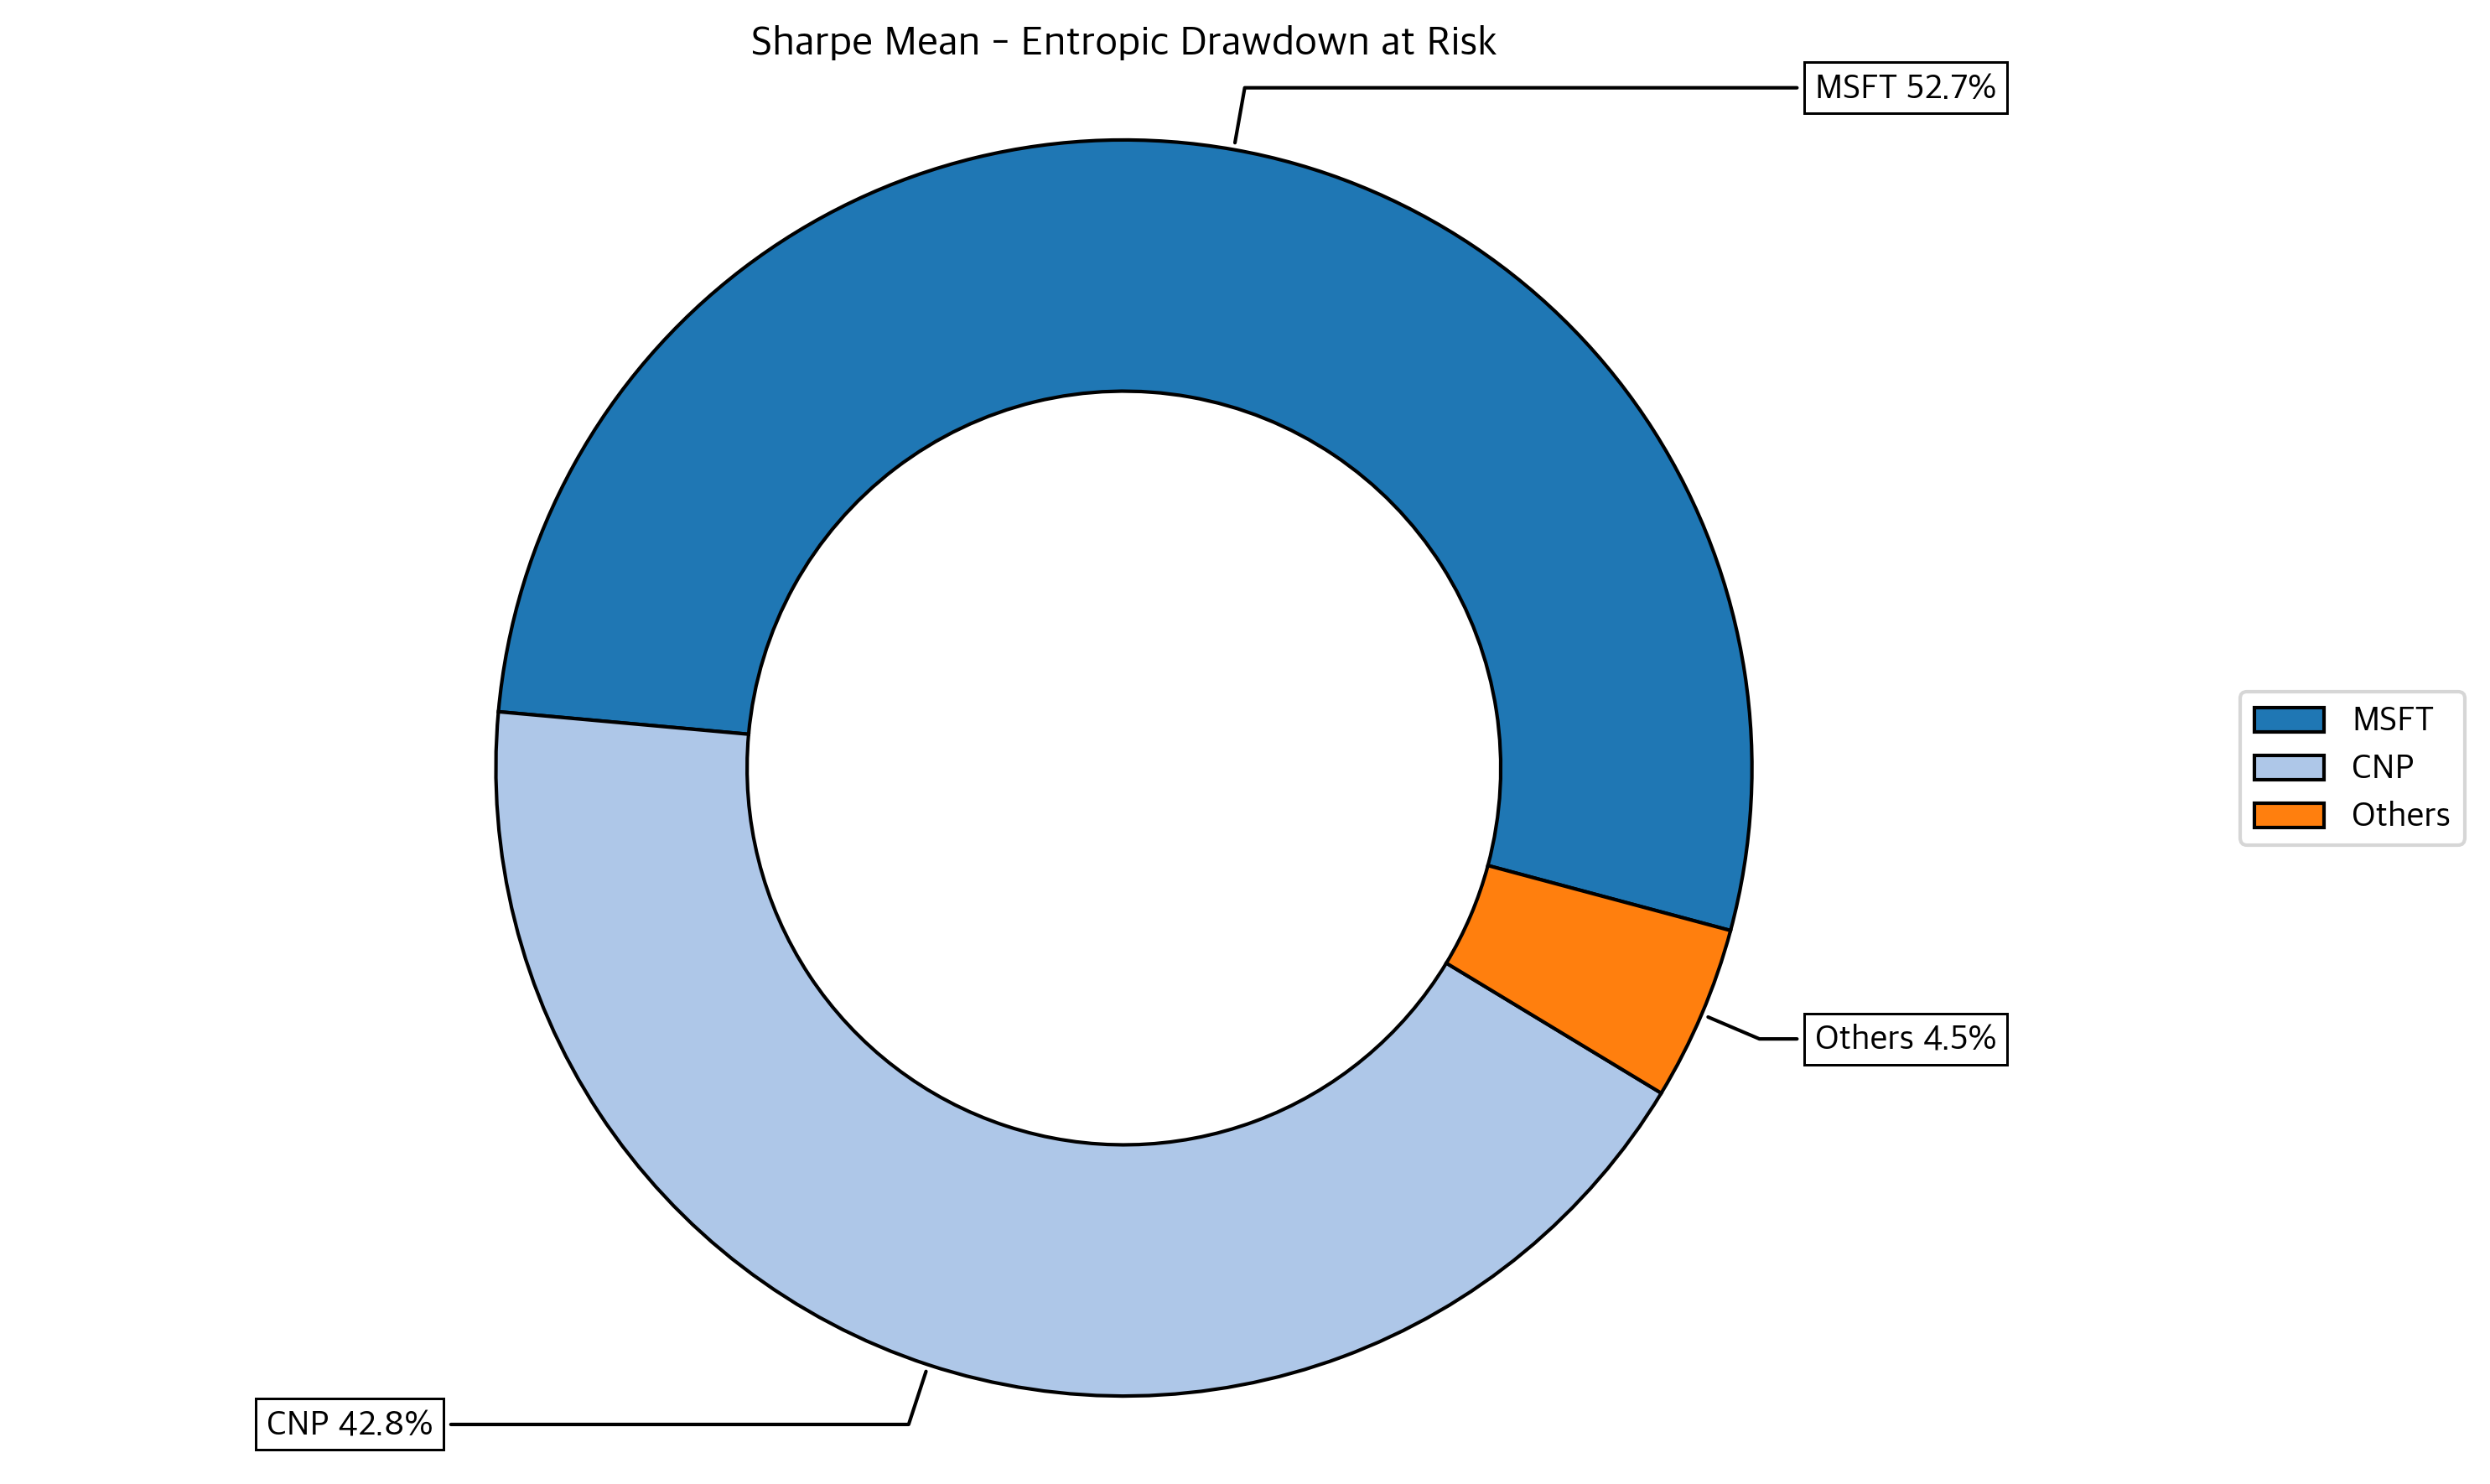

In [16]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe Mean - Entropic Drawdown at Risk', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### 2.3 Plotting risk measures

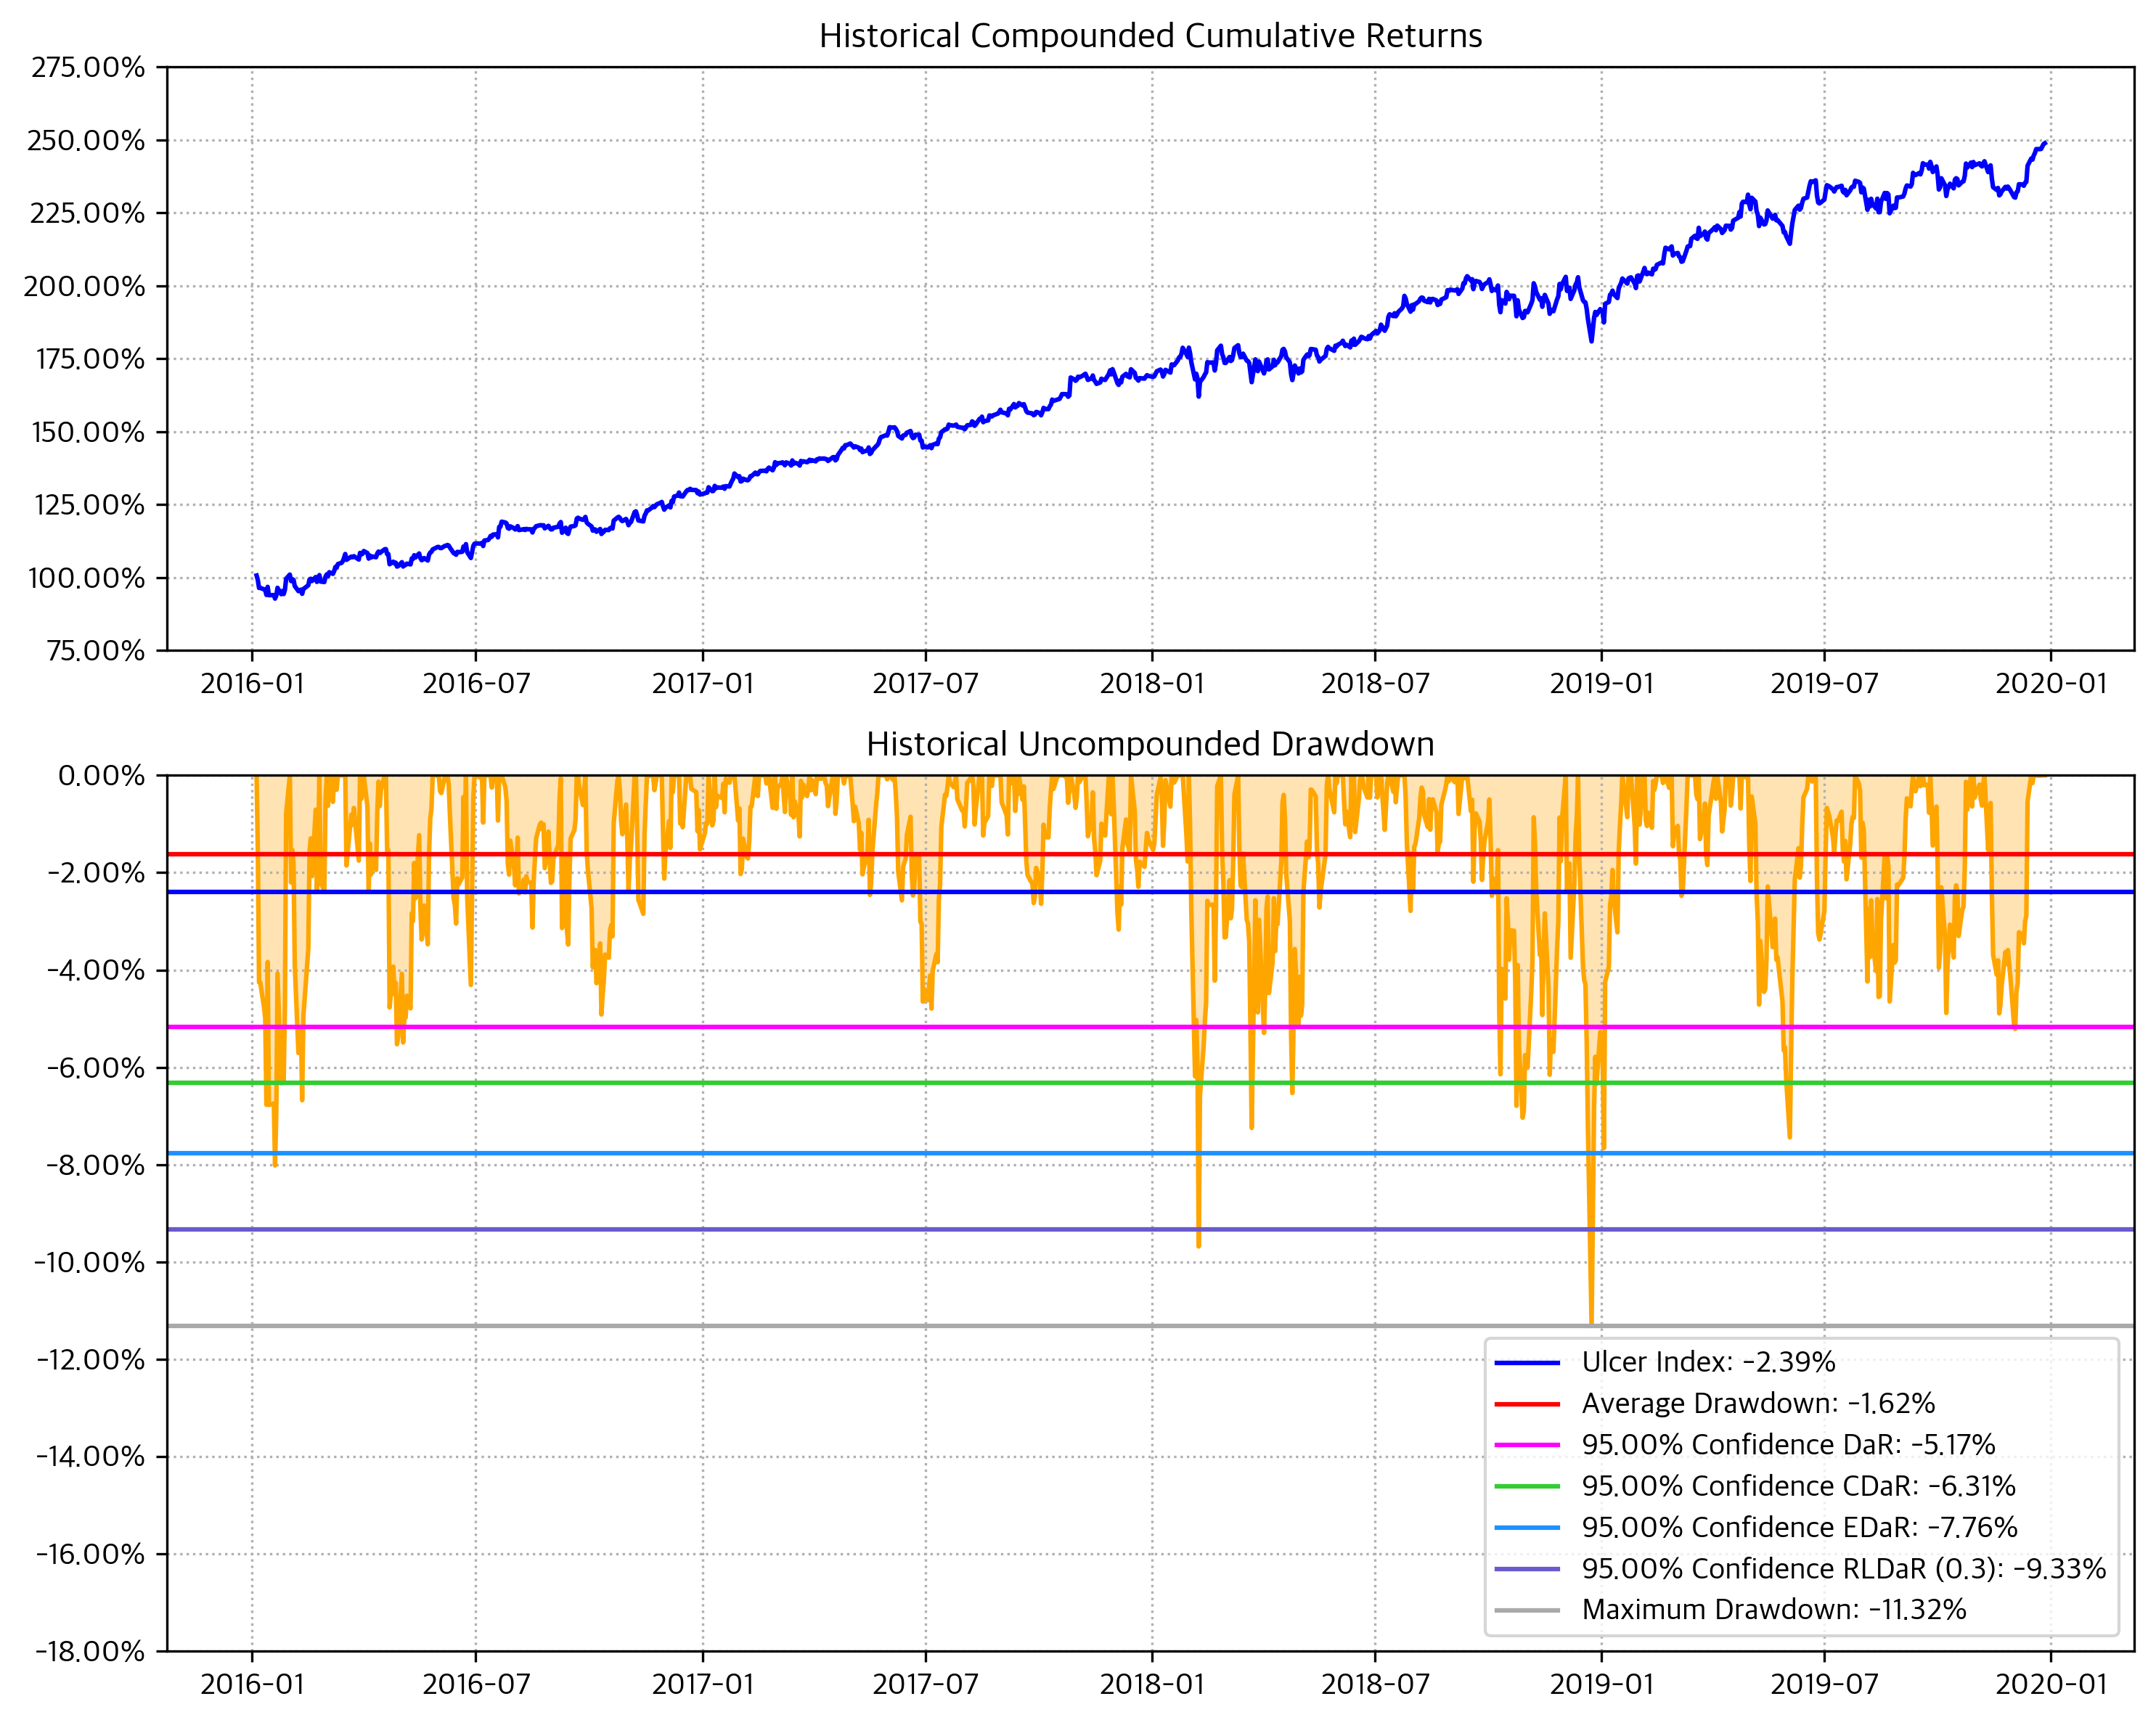

In [17]:
# Plotting the drawdown risk measures

ax = rp.plot_drawdown(returns=Y,
                      w=w,
                      alpha=0.05,
                      height=8,
                      width=10,
                      height_ratios=[2, 3],
                      ax=None)

### 2.4 Calculate efficient frontier

In [18]:
points = 40 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
0,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,35.4964%,0.0000%,0.0000%,0.0000%,0.0000%,...,2.6255%,5.7585%,13.9719%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,8.4229%,3.1939%
1,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,42.9441%,0.0000%,0.0000%,0.0000%,0.0000%,...,2.7806%,1.3038%,2.6000%,0.0000%,0.0000%,1.5200%,0.0000%,0.0000%,6.8443%,0.0000%
2,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,42.9987%,0.0000%,0.5773%,0.0000%,0.0000%,...,3.0056%,0.0000%,0.1450%,0.0000%,0.0000%,4.0530%,0.0000%,0.0000%,5.3210%,0.0000%
3,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,40.8560%,0.0000%,2.6491%,0.0000%,0.0000%,...,2.7279%,0.0000%,0.0000%,0.0000%,0.0000%,1.0977%,0.0000%,0.0000%,5.8180%,0.0000%
4,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,42.0038%,0.0000%,2.6448%,0.0000%,0.0000%,...,1.2939%,0.0000%,0.0000%,0.0000%,0.0000%,0.8486%,0.0000%,0.0000%,3.0876%,0.0000%


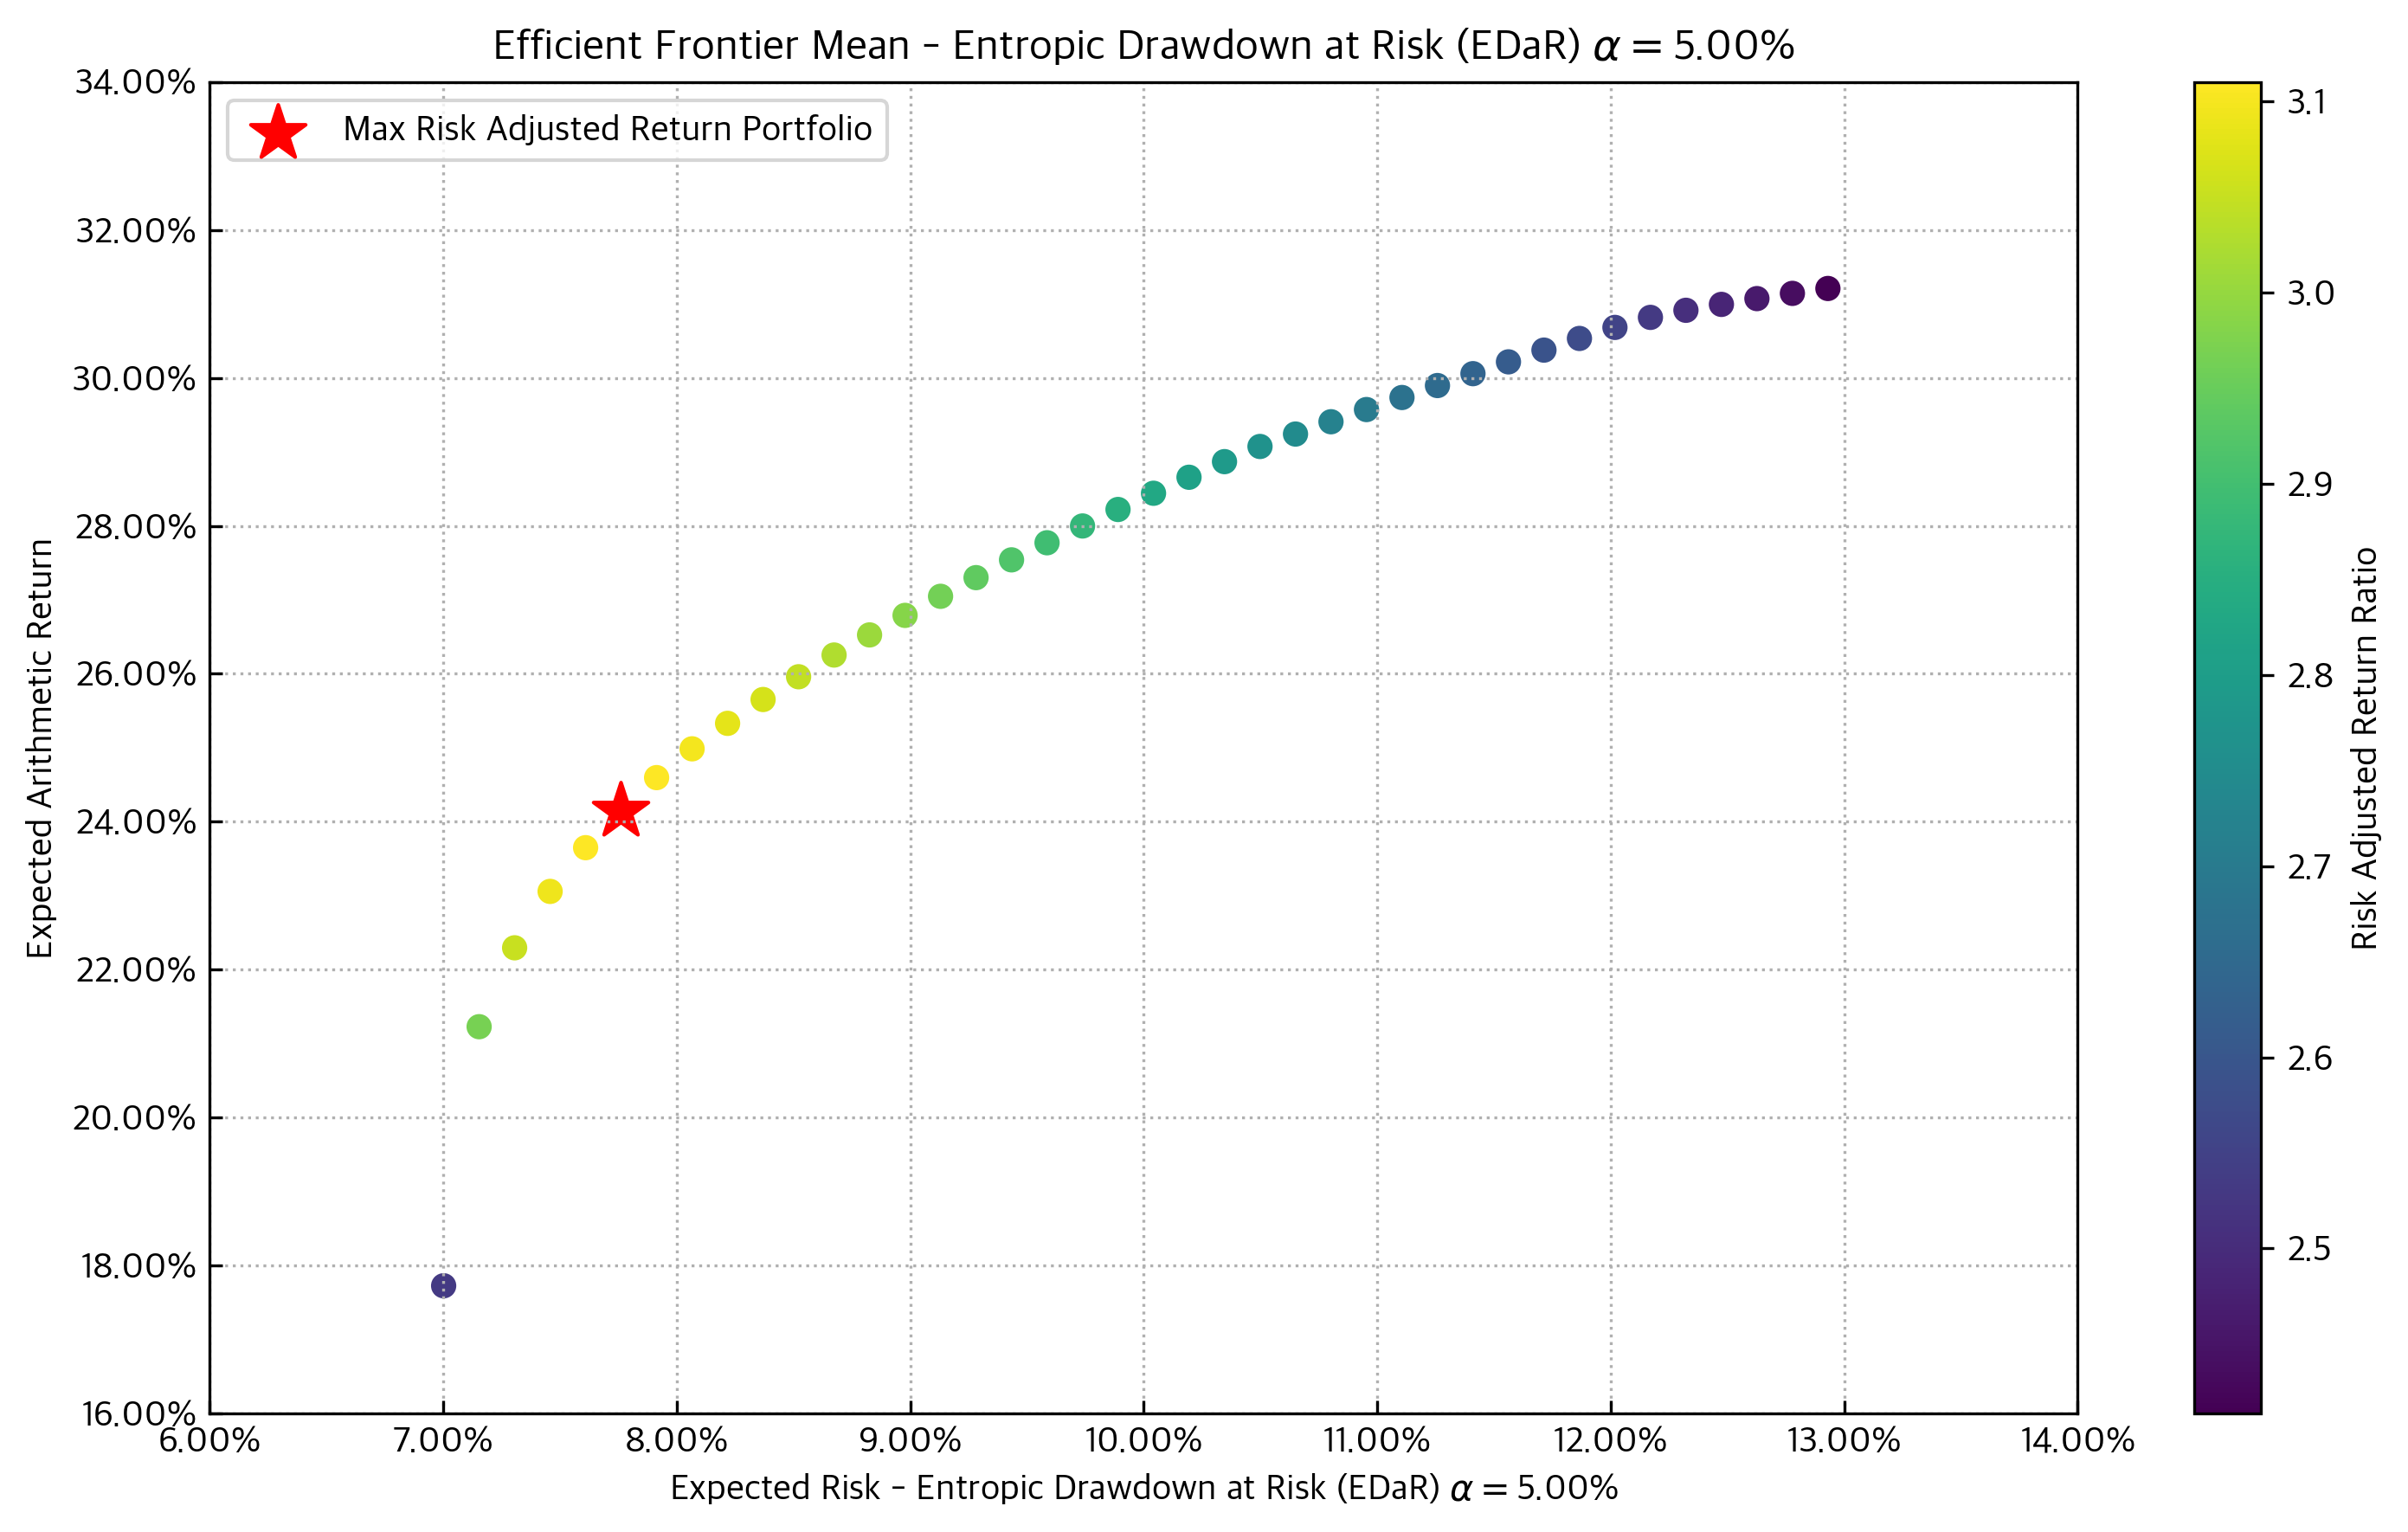

In [19]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

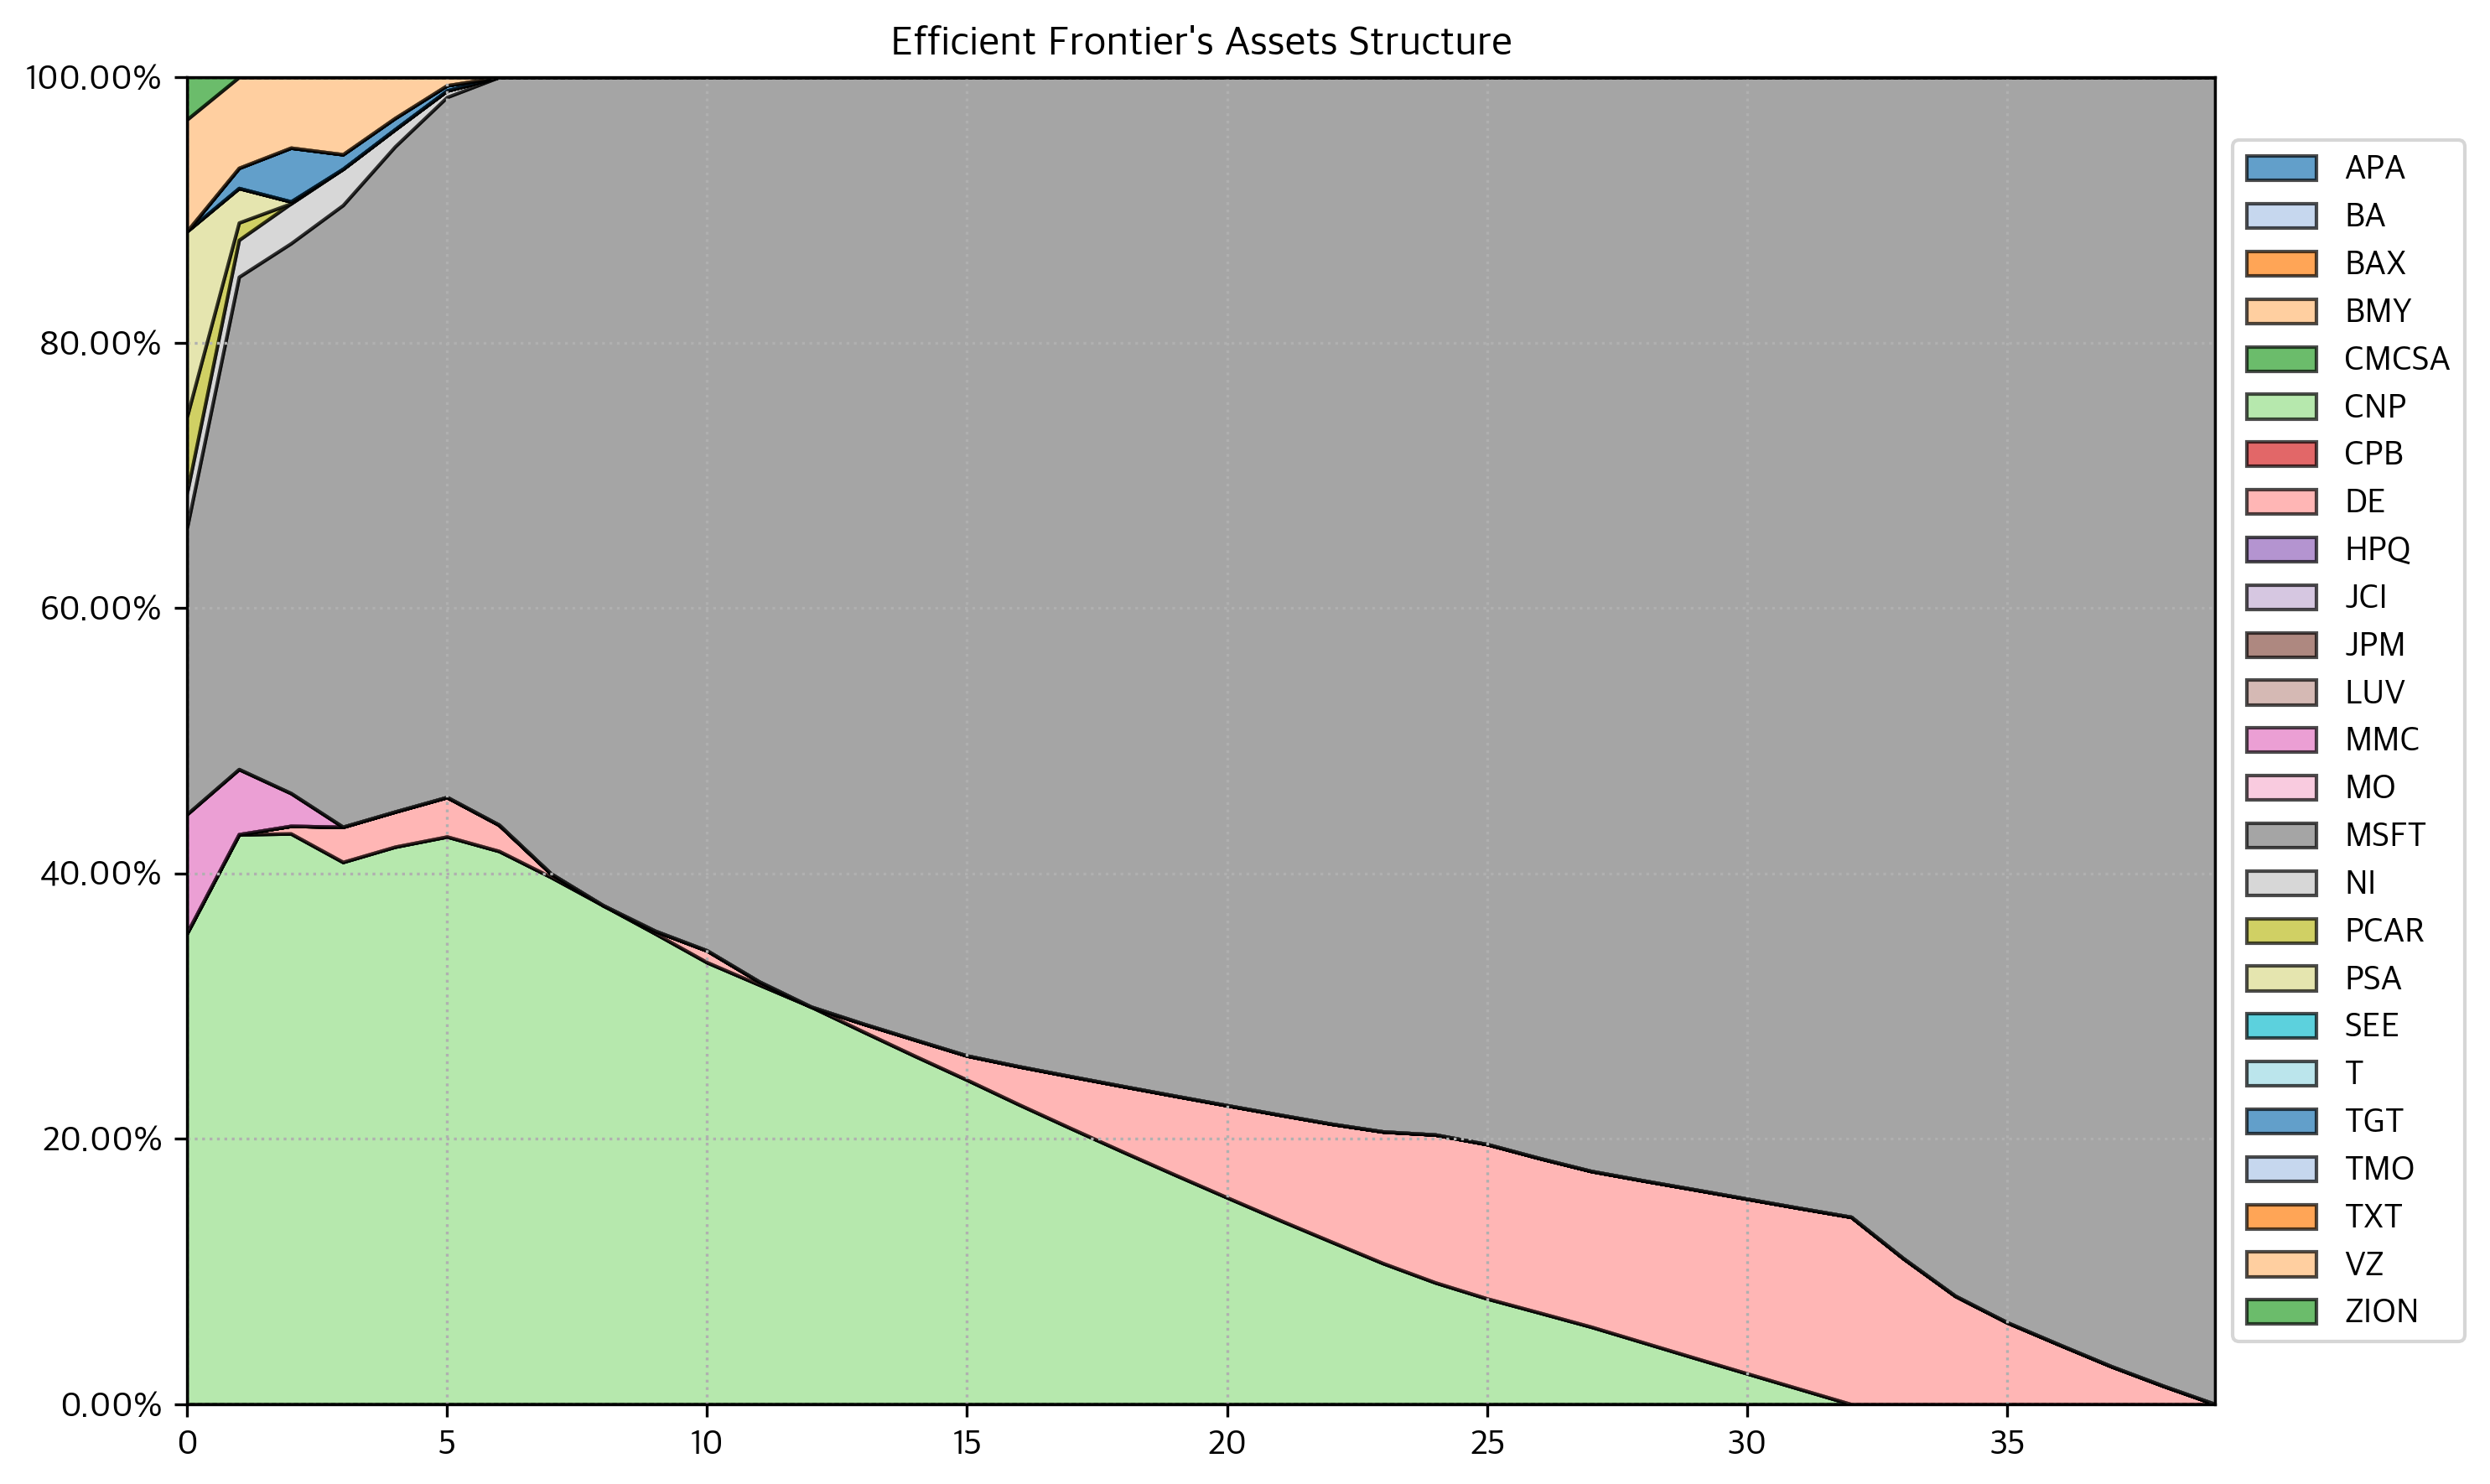

In [20]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

## 3. Estimating Risk Parity Portfolios for EDaR

### 3.1 Calculating the risk parity portfolio for EDaR.


EDaR 리스크 측정을 위한 리스크 패리티 포트폴리오는 다음 문제의 해법입니다:

$$
\min_{w, z} \quad EDaR_{\alpha}(rw) - b \ln(w)
$$

$$
\text{s.t.} \quad 1^T w = 0
$$

$$
\quad \quad \quad w \geq 0
$$

여기서 $w$는 자산의 가중치이고, $b$는 제약 조건의 벡터입니다. 기본적으로 자산의 개수에 대한 1/(자산의 개수)로 이루어진 벡터입니다.

In [21]:
b = None # Risk contribution constraints vector

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_rp.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,1.0521%,4.2259%,2.6895%,2.2434%,3.5913%,9.1446%,2.6435%,7.1228%,2.4262%,1.9664%,...,5.4977%,2.2483%,12.5406%,2.3575%,3.0458%,1.7430%,3.9957%,1.3705%,11.0815%,2.4701%


### 3.2 Plotting portfolio composition

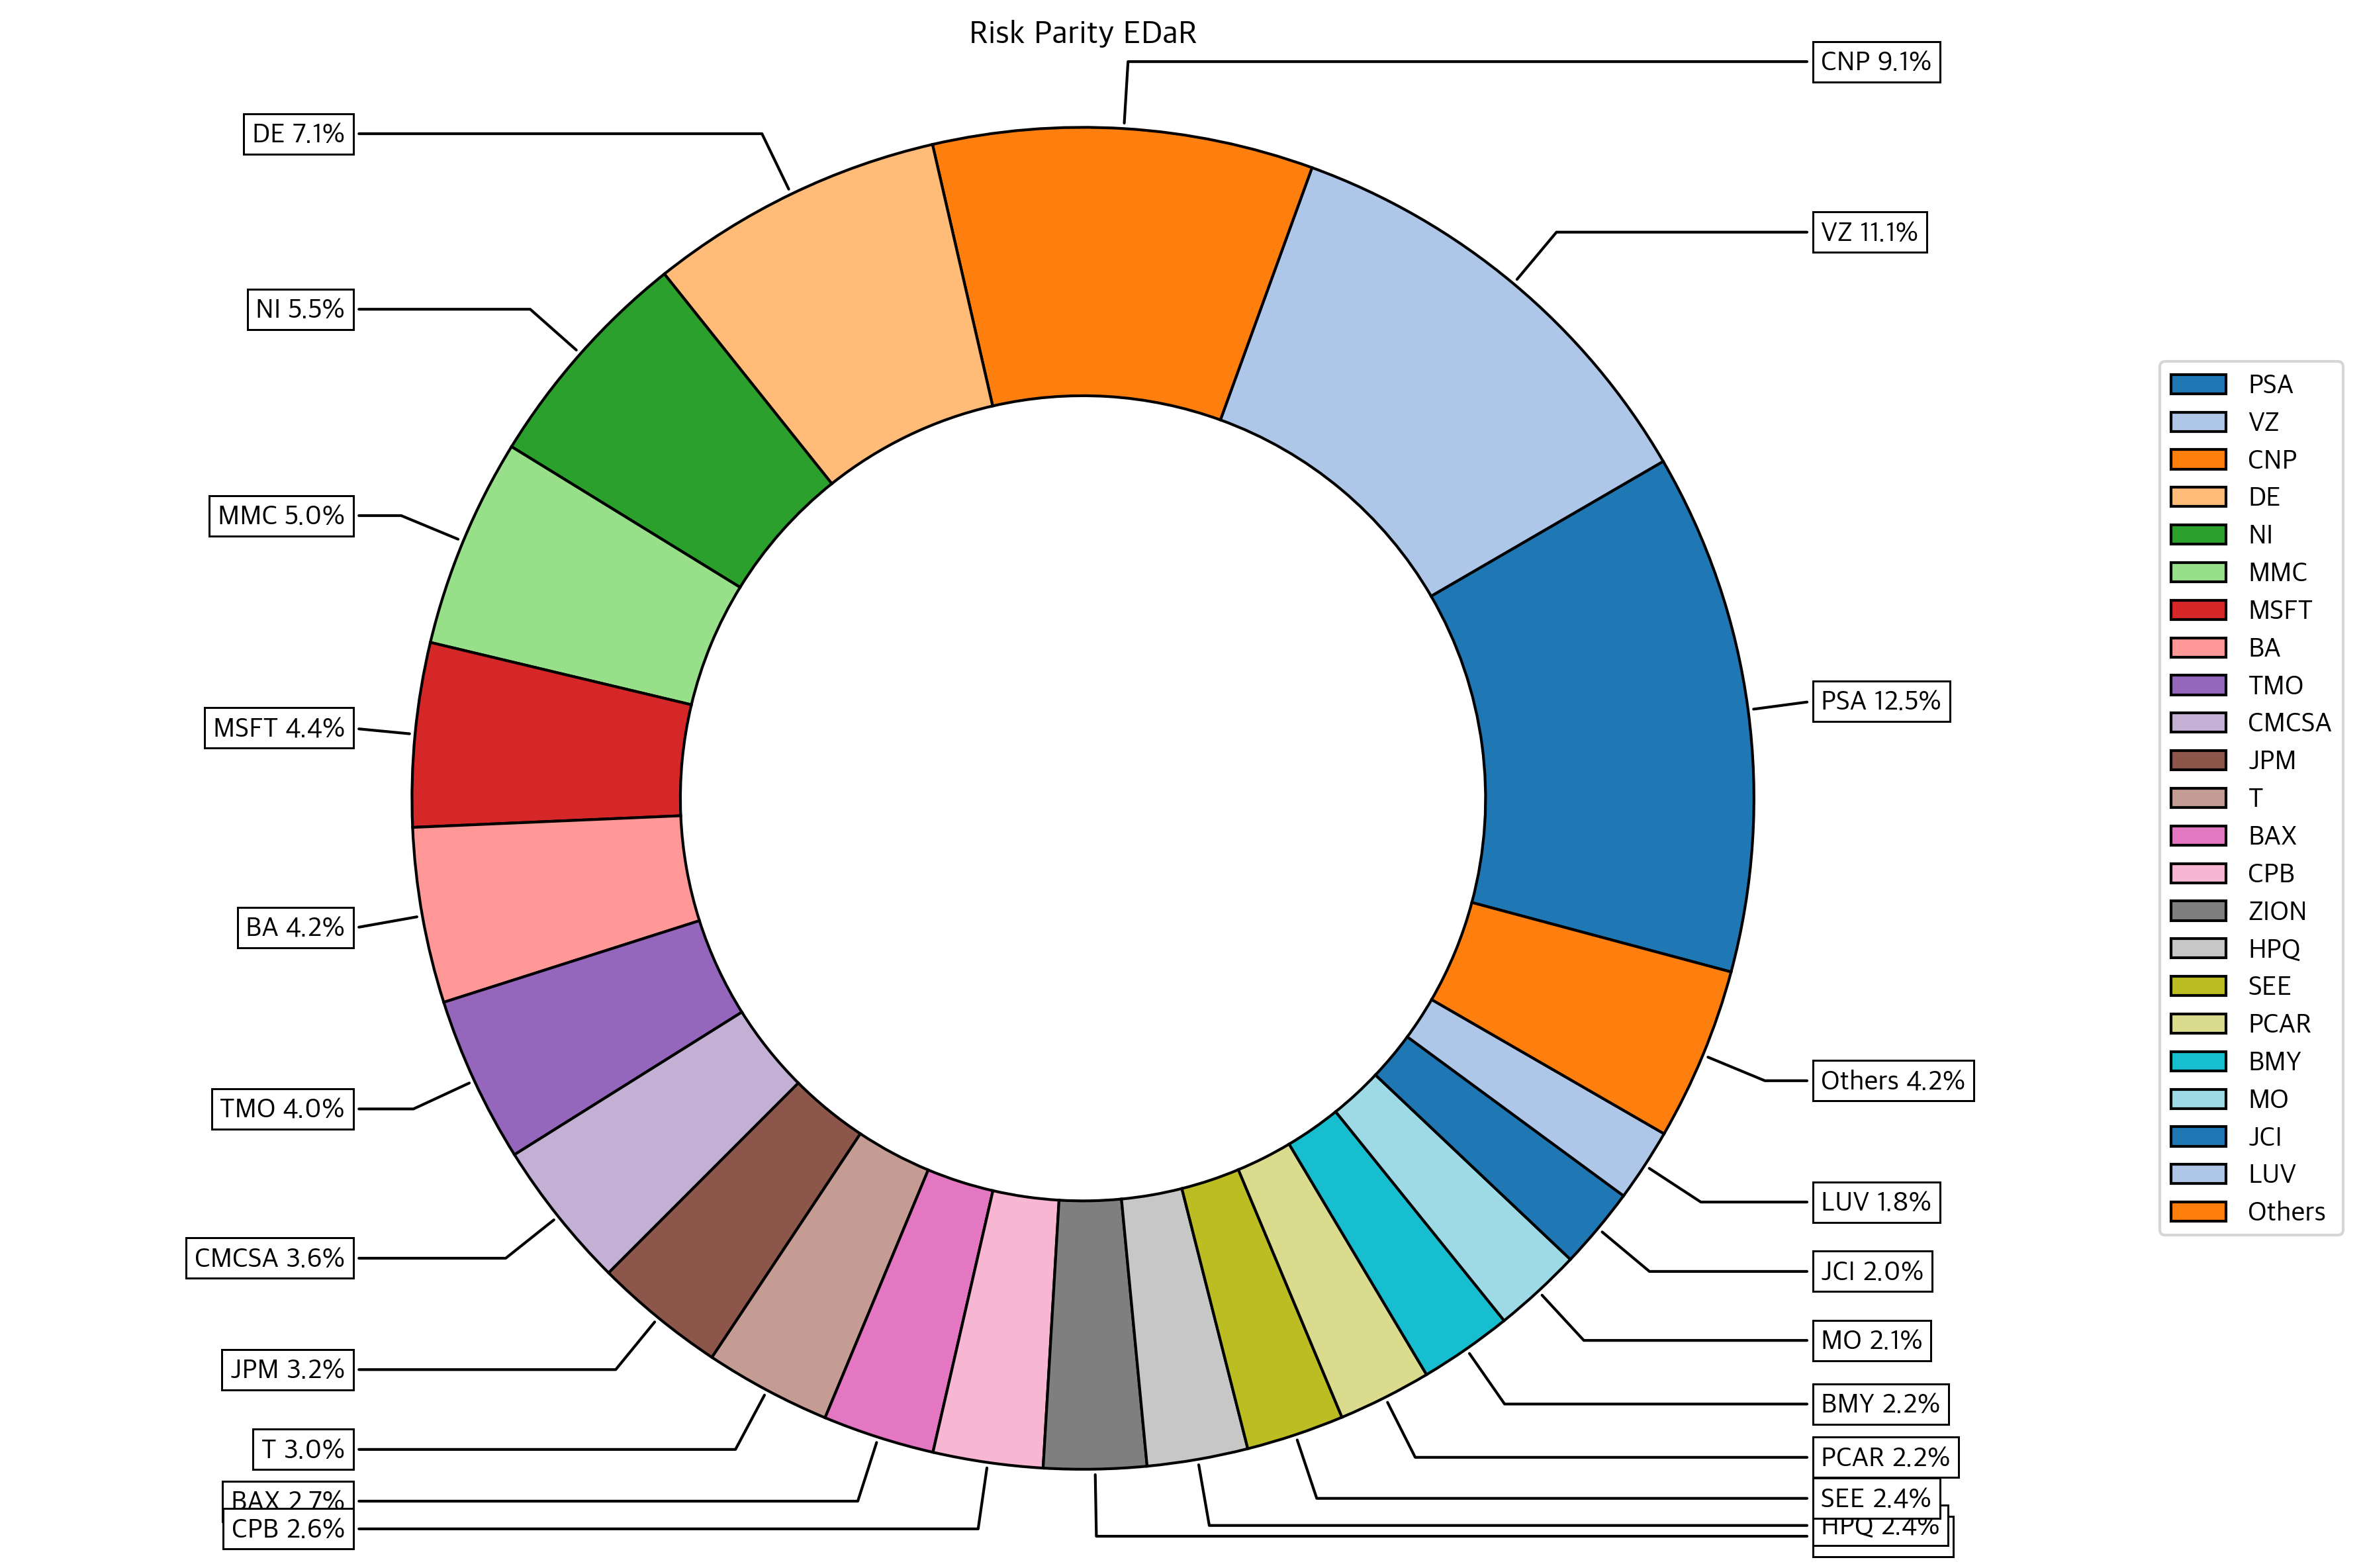

In [22]:
ax = rp.plot_pie(w=w_rp, title='Risk Parity EDaR', others=0.05, nrow=25, cmap = "tab20",
                 height=8, width=12, ax=None)

### 3.3 Plotting Risk Composition

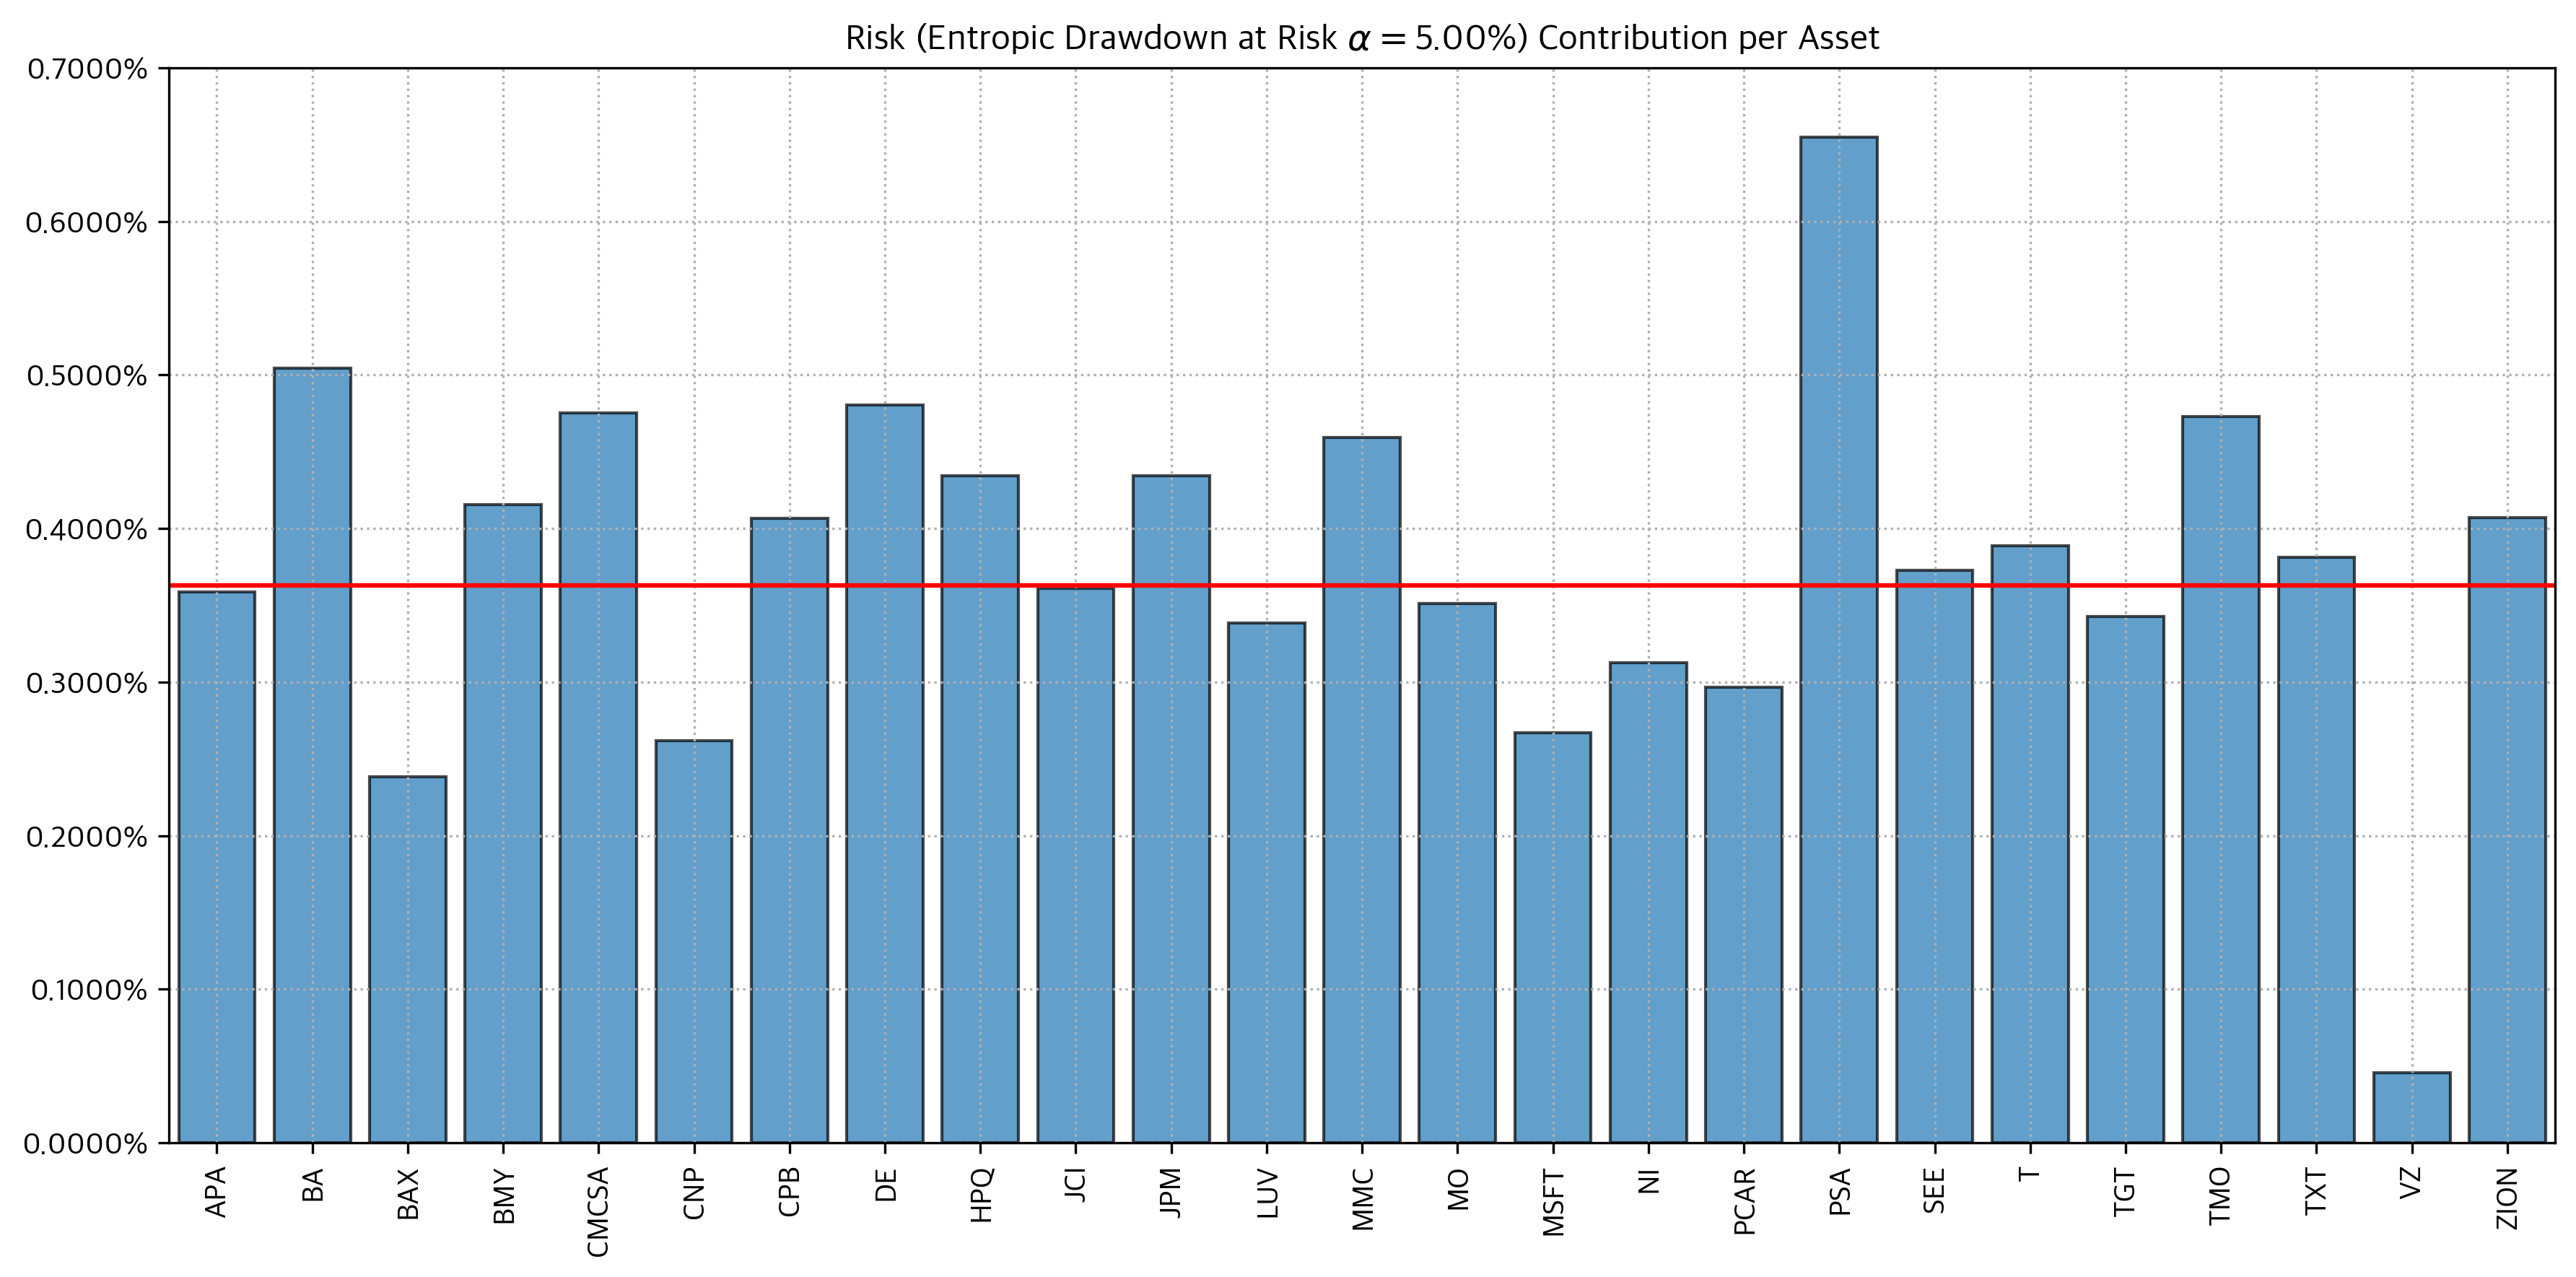

In [23]:
ax = rp.plot_risk_con(w_rp, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.05,
                      color="tab:blue", height=6, width=12, ax=None)